## Imports

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np

import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from IPython.display import clear_output
import time
start = time.time()

## Data and parameters

In [2]:
DATA_PATH = 'E:/Projects/Datacup/'
seed = 32
np.random.seed(seed=seed)

In [3]:
train = pd.read_csv(DATA_PATH+'performance_train.csv')
test = pd.read_csv(DATA_PATH+'performance_test.csv')
train_fac = pd.read_csv(DATA_PATH + 'facturation_train.csv')
test_fac = pd.read_csv(DATA_PATH + 'facturation_test.csv')

compl = pd.concat([train,test],axis=0,ignore_index=True)
compl.loc[:len(train),'trainset']=1
compl.loc[len(train):,'trainset']=0

compl_fac = pd.concat([train_fac,test_fac],axis=0).sort_values(['ID_CPTE','PERIODID_MY'])

In [4]:
compl_fac['ratio_ctotal_credit'] = compl_fac['CurrentTotalBalance']/compl_fac['CreditLimit']

In [5]:
compl_fac.fillna(0,inplace=True)

## Features

In [6]:
numericals = []

In [7]:
def get_agg_compte(data,var,agg,numericals):
    gp = data.groupby(['ID_CPTE']).agg({var:agg})
    if not agg+var in numericals:
        numericals.append(agg+var)
    compl[agg+var]=compl['ID_CPTE'].map(gp[var])

def get_lags_compte(data,var,lags,numericals):
    gp = data.groupby(['ID_CPTE'])
    for lag in lags:
        compl[var+str(lag)] = compl['ID_CPTE'].map(gp[var].nth(lag))
        if not var+str(lag) in numericals:
            numericals.append(var+str(lag))

In [8]:
get_agg_compte(compl_fac,'CurrentTotalBalance','last',numericals)
get_agg_compte(compl_fac,'CashBalance','last',numericals)
get_agg_compte(compl_fac,'CreditLimit','last',numericals)
compl['ratio_last_credit_totalcash'] = compl['lastCurrentTotalBalance']/compl['lastCreditLimit']
numericals.append('ratio_last_credit_totalcash')
get_agg_compte(compl_fac,'DelqCycle','last',numericals)
get_agg_compte(compl_fac,'CashBalance','mean',numericals)
get_agg_compte(compl_fac,'DelqCycle','mean',numericals)
get_agg_compte(compl_fac,'CreditLimit','median',numericals)
get_agg_compte(compl_fac,'CashBalance','first',numericals)
get_agg_compte(compl_fac,'DelqCycle','first',numericals)
get_agg_compte(compl_fac,'DelqCycle','std',numericals)
get_agg_compte(compl_fac,'CreditLimit','std',numericals)
get_lags_compte(compl_fac,'ratio_ctotal_credit',[-2,-3,-4,-5,-6],numericals)
get_lags_compte(compl_fac,'CurrentTotalBalance',[-2,-3,-4,-5,-6],numericals) 
get_lags_compte(compl_fac,'DelqCycle',[-2,-3,-4,-5],numericals)
get_agg_compte(compl_fac,'DelqCycle','sum',numericals) 

In [9]:
target = 'Default'
features = numericals.copy()

tr_idx = np.where(compl.trainset==1)
test_idx = np.where(compl.trainset==0)
df_train = compl.iloc[tr_idx]
df_test = compl.iloc[test_idx]

X = df_train[features]
X_test = df_test[features]
y = df_train[target]

## Models

In [10]:
cat_params = {'logging_level':'Silent',
                  'learning_rate':0.05,
                  'iterations':300,
                  #'l2_leaf_reg':0.1,
                  'bagging_temperature':0.5,
                  'random_seed':seed,
                  'depth':4,
                  'od_type':"Iter",
                  'od_wait':70}

[245, 179, 294, 192, 185, 160, 286, 155, 170, 245]
Average ROC: 0.8979078531317469 Average trees: 211


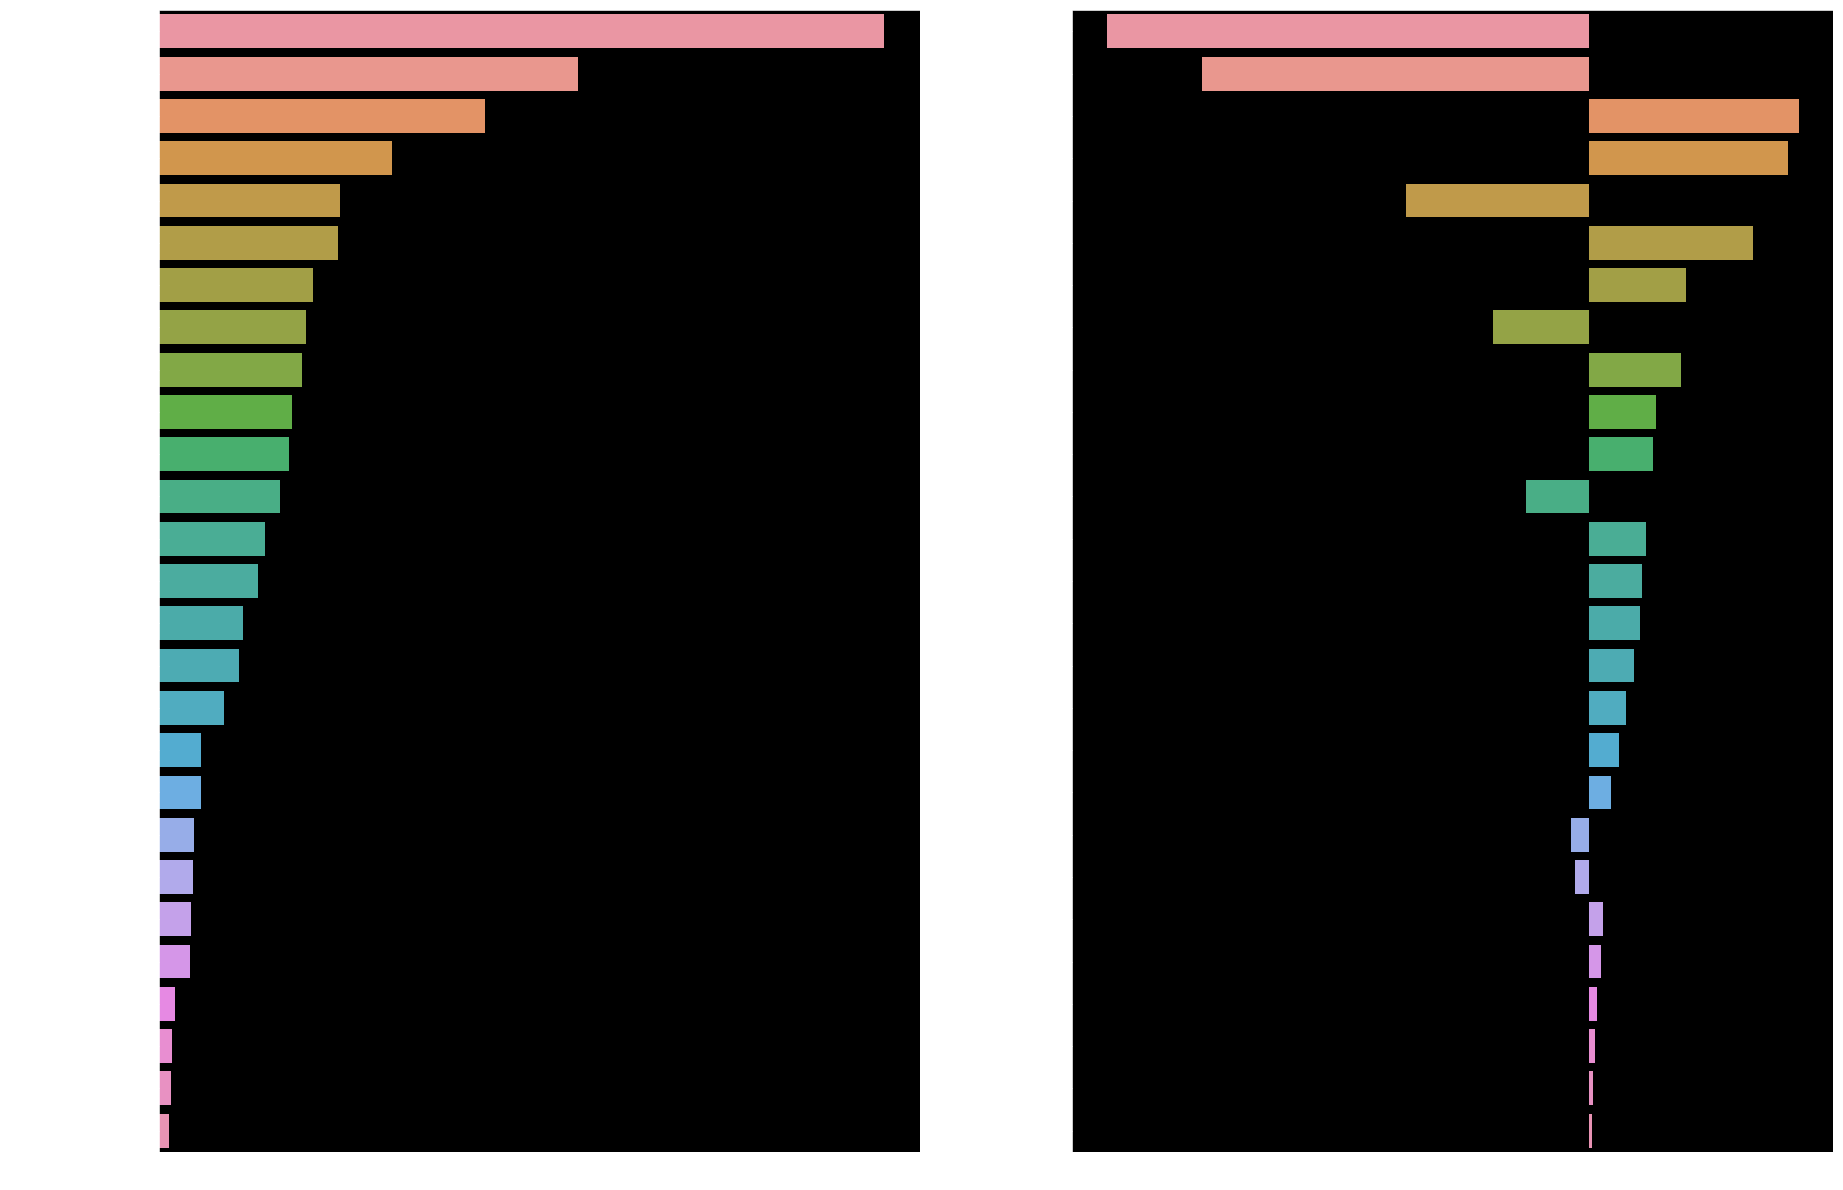

Wall time: 38.3 s


In [15]:
%%time
rocs = []
trees = []
feature_importances_split = []
feature_importances_shap = []
X_meta = np.zeros((compl.shape[0],2))
X_meta[:X.shape[0],0]=y

kf = KFold(10,shuffle=True,random_state=seed)
for train_idx, val_idx in kf.split(X):

    X_tr = X.iloc[train_idx]
    y_tr = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    cat_model = cb.CatBoostClassifier(**cat_params.copy())
    cat_model.fit(X=X_tr,y=y_tr,eval_set=(X_val,y_val),cat_features=[],use_best_model=True)

    predict_tr = cat_model.predict(X_tr,prediction_type='Probability')[:,1]
    roc_auc_tr = roc_auc_score(y_tr,predict_tr)

    predict_val = cat_model.predict(X_val,prediction_type='Probability')[:,1]
    X_meta[val_idx,1]=predict_val
    roc_auc = roc_auc_score(y_val,predict_val)

    rocs.append(roc_auc)
    trees.append(cat_model.tree_count_)
    if len(cat_model.feature_importances_) == len(features):
        feature_importances_split.append(cat_model.feature_importances_)

    cp = cb.Pool(X_val,y_val,cat_features = [])
    fi = cat_model.get_feature_importance(cp,fstr_type='ShapValues')[:,:-1]
    feature_importances_shap.append(fi)
    print('TRAIN:',roc_auc_tr,'VAL:',roc_auc)

clear_output()
avg_trees = sum(trees)//len(trees)
print(trees)
avg_roc = sum(rocs)/len(rocs)
print('Average ROC:',avg_roc,'Average trees:',avg_trees)

feature_importances_split = np.stack(feature_importances_split).mean(axis=0)
feature_importances_shap = (np.stack(feature_importances_shap).mean(axis=0)).mean(axis=0)
importances = pd.DataFrame({'Name':features,'Shap':list(feature_importances_shap),
                 'Split':list(feature_importances_split)})
importances['Shap_abs'] = np.abs(feature_importances_shap)
feature_sort = 'Split'
importances = importances.sort_values(feature_sort,ascending=False)
fig, ax = plt.subplots(figsize=(30,21),nrows=1,ncols=2)
sns.barplot(x=feature_sort, y='Name',data=importances[:30], ax=ax[0])
importances = importances.sort_values('Shap_abs',ascending=False)
sns.barplot(x='Shap', y='Name',data=importances[:30], ax=ax[1])
plt.show() 

In [16]:
cat_model = cat_model.fit(X=X,y=y,cat_features=[])
start_pred = time.time()
predict_test = cat_model.predict(X_test,prediction_type='Probability')[:,1]
print(time.time()-start_pred)
test['Default'] = predict_test
X_meta[X.shape[0]:,1]=predict_test
#test[['ID_CPTE','Default']].to_csv('SinglePredictions/'+f'{avg_roc:.5f}_'+'CBS_full.csv',index=False)
np.save('../Stacksfull/'+f'{avg_roc:.5f}_'+'MetaCBS_full.npy',X_meta)

0.009023666381835938


In [13]:
print(time.time()-start)

45.02274250984192
